# LED Matrix Simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import board as bd
import animations as animat
from IPython.display import HTML
import scipy as sp
import os
import json
%matplotlib inline

## 2-Bit Random Noise

In [2]:
myBoard = bd.Board()

In [3]:
# two bit
state = np.random.rand(np.sum(myBoard.colNs))>0.5

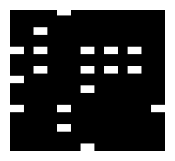

In [4]:
plt.figure(figsize = (2,2))
plt.imshow(myBoard.renderBoardState(state), origin = 'lower', cmap='grey');
plt.axis('off');

In [5]:
%%capture
duration = 10 #seconds
framerate = 30 #frames per second
states = np.random.rand(duration*framerate, np.sum(myBoard.colNs))>0.5 #two bit states
ani = myBoard.animateBoard(states, framerate = framerate)

In [6]:
HTML(ani.to_jshtml())

## n-Bit Patterns

Maximum time of the animation that can be stored in 16kB

In [7]:
maxBit = 31 #5 bit
bitDepth = np.log2(maxBit+1) #bits
fps = 30
imgSize = 42 #bits
memory = 16e3 #bytes
maxTime = memory/((imgSize*bitDepth/8)*fps) #seconds
print("Maximum time for a {} bit image at {} fps with {} bit depth is {} seconds".format(imgSize, fps, bitDepth, maxTime))

Maximum time for a 42 bit image at 30 fps with 5.0 bit depth is 20.317460317460316 seconds


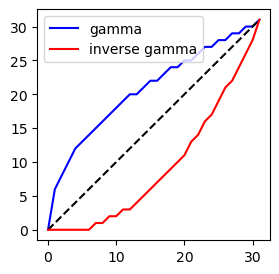

In [8]:
plt.figure(figsize= (3,3));
plt.plot(np.arange(maxBit+1), bd.gammaPercept(np.arange(maxBit+1), gamma=2.2, maxBit = maxBit), 'b-', label = 'gamma');
plt.plot(np.arange(maxBit+1), np.arange(maxBit+1), 'k--');
plt.plot(np.arange(maxBit+1), bd.gammaCorrect(np.arange(maxBit+1), gamma=2.2, maxBit = maxBit), 'r-', label = 'inverse gamma');
plt.legend();

In [9]:
%%capture
duration = 10 #seconds
states = bd.gammaCorrect(np.round(np.random.rand(duration*fps, np.sum(myBoard.colNs))*maxBit).astype('int'), gamma=2.2, ) #two bit states
ani = myBoard.animateBoard(states, framerate = fps)

In [10]:
HTML(ani.to_jshtml())

## Hopfield Owlet

In [11]:
W = animat.HopfieldNetwork(np.sum(myBoard.colNs))
W.train([animat.owlet('sleeping'), animat.owlet('not sleeping')])

In [12]:
np.random.seed(14)
evolutionHopfield = W.recall(animat.owlet('sleeping'), noise=0.05, steps = 40, updateNeurons=10, pushFrequency=15, pushPattern = animat.owlet('wink'))

In [13]:
print('time of the reflecting animation: {} seconds'.format(2*len(evolutionHopfield)/fps))

time of the reflecting animation: 13.333333333333334 seconds


In [14]:
%%capture
ani = myBoard.animateBoard(bd.enforceState(evolutionHopfield,maxBit = maxBit,correctGamma=True,gamma=2.2), framerate = framerate)

In [15]:
HTML(ani.to_jshtml())

## Kuramoto LEDs

In [16]:
# Example usage
np.random.seed(0)
evolutionKuramoto = animat.kuramotoLEDs(n=42, omega=0.12, K=0.1, time_steps=100, heterogeneity=0.03)

In [17]:
print('time of the animation: {} seconds'.format(len(evolutionKuramoto)/fps))

time of the animation: 3.3333333333333335 seconds


In [18]:
%%capture
ani = myBoard.animateBoard(bd.enforceState(evolutionKuramoto, maxBit, gamma=2.2), framerate = framerate)

In [19]:
HTML(ani.to_jshtml())

# Final Animation

In [20]:
finState = np.vstack([bd.enforceState(evolutionKuramoto, maxBit=maxBit, correctGamma=True, gamma=2.2),
                      np.flip(bd.enforceState(evolutionHopfield,maxBit = maxBit,correctGamma=True,gamma=2.2), axis = 0)
           ])


In [21]:
%%capture
ani = myBoard.animateBoard(finState, framerate = fps)

In [22]:
HTML(ani.to_jshtml())

In [23]:
print('time of the animation: {} seconds'.format(len(finState)/fps))

time of the animation: 10.0 seconds


## Decompose into binary images and save as C# header

In [24]:
frames = myBoard.decompose(finState, maxBit = maxBit)

In [25]:
saveFolder = '../headers'
if not os.path.exists(saveFolder):
    os.makedirs(saveFolder)

In [26]:
# Define output C header file
header_filename = f"{saveFolder}/frames.h"

# Header file content
header_content = f"""\

// LED Patterns: Each row packed into 6 bytes
const uint8_t frames[] = {{
"""

# Convert the NumPy array into packed 42-bit values stored as 6 bytes
for frame in range(frames.shape[1]):
    header_content += "    {\n"
    for bit in range(frames.shape[0]):
        # Convert the 42-bit binary sequence to 6 packed bytes
        binary_str = "".join(map(str, frames[bit, frame]))
        packed_bytes = [int(binary_str[i:i+8], 2) for i in range(0, frames.shape[2], 8)]
        
        # Compact formatting: No extra spaces or comments
        hex_values = ",".join(f"0x{byte:02X}" for byte in packed_bytes)
        header_content += f"        {{{hex_values}}},\n"

    header_content += "    },\n"

header_content += "};\n\n // LED_PATTERNS_H\n"

# Write to the header file
with open(header_filename, "w") as f:
    f.write(header_content)

print(f"Header file '{header_filename}' has been generated successfully.")

Header file '../headers/frames.h' has been generated successfully.


# Fonts

In [27]:
fontStates = bd.enforceState(np.load('fontArray.npy'), maxBit=maxBit, correctGamma=True, gamma=2.2, low=0, high=1)
# Load the list from JSON
with open("fontCharacters.json", "r") as file:
    characters = json.load(file)

In [28]:
%%capture
ani = myBoard.animateBoard(fontStates, framerate = fps, titles = characters)


In [29]:
HTML(ani.to_jshtml())

In [30]:
fonts = myBoard.decompose(fontStates, maxBit = maxBit)

In [31]:
# Define output C header file
header_filename = f"{saveFolder}/fonts.h"

# Header file content
header_content = f"""\

// LED Patterns for each character: Each row packed into 6 bytes
const uint8_t frames[] = {{
"""

# Convert the NumPy array into packed 42-bit values stored as 6 bytes
for char in range(fonts.shape[1]):
    header_content += "    {\n"
    for bit in range(fonts.shape[0]):
        charname = f" // {characters[char]}" if bit == 0 else ""
        # Convert the 42-bit binary sequence to 6 packed bytes
        binary_str = "".join(map(str, fonts[bit, char]))
        packed_bytes = [int(binary_str[i:i+8], 2) for i in range(0, fonts.shape[2], 8)]
        
        # Compact formatting: No extra spaces or comments
        hex_values = ",".join(f"0x{byte:02X}" for byte in packed_bytes)
        header_content += f"        {{{hex_values}}}," + charname + "\n"

    header_content += " },\n"

header_content += "};\n\n // LED_PATTERNS_H\n"

# Write to the header file
with open(header_filename, "w") as f:
    f.write(header_content)

print(f"Header file '{header_filename}' has been generated successfully.")

Header file '../headers/fonts.h' has been generated successfully.
